In [1]:
%load_ext autoreload
%autoreload 2
import sklearn.preprocessing as pre, scipy, numpy as np, matplotlib.pyplot as plt, glob, pickle, pyemma as py, sys, os
import pandas as pd
import seaborn as sns 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
%matplotlib inline
from temp_tf_load import *
sys.path.append('../')
from hde import HDE, analysis
lag_time = 10
import warnings
warnings.filterwarnings('ignore')


/home/mikejones/anaconda3/lib/python3.7/site-packages/pyemma/__init__.py:92: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.7, you have 2.5.6.
  .format(latest=latest, current=current), category=UserWarning)
Using TensorFlow backend.


In [2]:
tf.__version__

'1.14.0'

In [5]:
# load pairwise distances and dihedral angles computed from simulation trajectory
pairwise_dis = np.load('/home/kengyangyao/data/HDE_data/alanine_dipeptide/pairwise_dis.npy')
#pairwise_dis = np.load('/home/pme/srv/srv/dna_data/pairwise_dis.npy')
#thermo_features = np.load('/home/pme/srv/srv/dna_data/thermo-332-1000-10.npy')
#pwd_features = np.load('/home/pme/srv/srv/dna_data/pwd-332-1000-190.npy')
dihedrals = np.load('/home/kengyangyao/data/HDE_data/alanine_dipeptide/dihedrals.npy')
scaler = pre.MinMaxScaler(feature_range=(-1, 1))
pairwise_dis_s = scaler.fit_transform(pairwise_dis)

scaler.fit(np.concatenate(thermo_features))
thermo_features_s = [scaler.transform(item) for item in dihedrals]

scaler.fit(np.concatenate(pwd_features))
pwd_features_s = [scaler.transform(item) for item in pwd_features]

print(np.shape(thermo_features))
print(np.shape(pwd_features))

print(thermo_features[0][0, 0])
print(thermo_features[100][0, 0])

print(pwd_features[0][5, 5])
print(pwd_features[100][5, 5])
#cossin_dihedrals = np.concatenate([np.cos(dihedrals), np.sin(dihedrals)], axis=1)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kengyangyao/data/HDE_data/alanine_dipeptide/pairwise_dis.npy'

## kernel tICA

In [ ]:
from temp_ktica import *

In [4]:
# find landmarks, this may take a while.  We use 5000 landmarks in our paper, but it 
# takes very long time to do clustering, so here we use 2000 instead
from sklearn.cluster import KMeans
n_landmarks = 2000
kmeans = KMeans(init='k-means++', n_clusters=n_landmarks, n_init=10)
kmeans.fit(pairwise_dis_s[::50])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2000, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
# take longer than previous cell
temp_dataset = pairwise_dis_s
temp_landmarks = kmeans.cluster_centers_
for sigma in [2.0]:    #  # best sigma for scaled pairwise distances with 5000 landmarks
    ktica = Kernel_tica(3, lag_time=10, gamma=1./(2 * sigma ** 2), n_components_nystroem=len(temp_landmarks), 
                       landmarks = temp_landmarks)
    ktica_coords = ktica.fit_transform([temp_dataset])[0]
    print(sigma, ktica._tica.timescales[:5])
    ktica_timescales = ktica._tica.timescales[:3]

using landmarks


100%|██████████| 30/30 [03:45<00:00,  7.13s/it]                       


2.0 [663.30461311  36.73776355  16.85202968   4.13034719   4.01966179]


In [6]:
# these are precomputed ktica coordinates and timescales
# ktica_coords = np.load('/home/kengyangyao/data/hde_paper_results/adp_ktica_coords.npy')
# ktica_timescales = np.load('/home/kengyangyao/data/hde_paper_results/adp_ktica_timescales.npy')

## HDE

In [153]:
skip = 1
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)

'''
## for default pairwise setup
hde = HDE(45, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=50000, n_epochs=200, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])

## for thermo basepair features
hde = HDE(2, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=5000, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])
          
'''
hde = HDE(190, n_components=3, lag_time=lag_time // skip, dropout_rate=0, batch_size=5000, n_epochs=10, 
          validation_split=0.2, batch_normalization=True, learning_rate = 0.01,
          callbacks=[earlyStopping])


In [42]:
# hde.r_degree = 10    # pre-training, to speed up discovery of first few slowest modes
# hde.batch_size = 200000
# hde.n_epochs = 50
# hde.fit(pairwise_dis_s)
# hde._recompile = True
# hde.r_degree = 5
# hde.fit(pairwise_dis_s)
# hde.batch_size = 500000
# hde._recompile = True
# hde.r_degree = 2
# hde.n_epochs = 100
# hde.fit(pairwise_dis_s)

In [115]:
hde.r_degree = 2
hde.n_epochs = 100
hde.fit(np.concatenate(pwd_features))

Train on 265592 samples, validate on 66398 samples
Epoch 1/100
265592/265592 [==============================] - 7s 26us/step - loss: -3.0655 - val_loss: -3.2521
Epoch 2/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.2516 - val_loss: -3.2133
Epoch 3/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.2465 - val_loss: -3.2818
Epoch 4/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.2949 - val_loss: -3.1982
Epoch 5/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.3085 - val_loss: -3.3227
Epoch 6/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.3458 - val_loss: -3.3795
Epoch 7/100
265592/265592 [==============================] - 4s 15us/step - loss: -3.3750 - val_loss: -3.3820
Epoch 8/100
265592/265592 [==============================] - 4s 14us/step - loss: -3.3767 - val_loss: -3.4085
Epoch 9/100
265592/265592 [==============================] - 4s 14us/

HDE(activation=None, batch_normalization=True, batch_size=5000,
    callbacks=[<keras.callbacks.EarlyStopping object at 0x7f28b5f8ee48>],
    dropout_rate=0, hidden_layer_depth=None, hidden_size=None, input_size=190,
    l2_regularization=0.0, lag_time=10, latent_space_noise=0,
    learning_rate=0.01, n_components=3, n_epochs=100, validation_split=0.2,
    verbose=True)

In [116]:
hde_coords = [hde.transform(item) for item in pwd_features]
hde_timescales = hde.timescales_
print(hde_timescales)

[157.8024661   94.44493567  81.41508347]


In [244]:
## make data frame

skip = 100    #num coords to skip on plot

hde_coords_conc = np.concatenate(hde_coords[::skip])
thermo_features_conc = np.concatenate(thermo_features[::skip])

index_size = len(hde_coords_conc[:, 0])
print (np.shape(hde_coords_conc))
print (np.shape(thermo_features_conc))

df_hde = pd.DataFrame(data    = hde_coords_conc, 
                   columns = ['1st_sm', '2nd_sm', '3rd_sm'], 
                   index   = np.linspace(1, index_size, index_size))

feature_col_list = ['Step', 'nbp', 'E_bond', 'E_angle', 'E_dihed', 'ebp', 'ecstk', 'eexcl', 'dna_ecou', 'Temp']

#make additional df column for timestep
lin_x = [i for i in range(len(thermo_features[0]))] 
lin_x_list = []
for i in range(len(thermo_features)):
    lin_x_list.append(lin_x)
    
lin_x_conc = np.concatenate(lin_x_list[::skip])
print(np.shape(lin_x_conc))

df_thermo =  pd.DataFrame(data    = thermo_features_conc, 
                   columns = feature_col_list, 
                   index   = np.linspace(1, index_size, index_size))

df_thermo['time_traj'] = lin_x_conc
                          
df = df_hde.join(df_thermo)

print(df.head())

(4000, 3)
(4000, 10)
(4000,)
       1st_sm    2nd_sm    3rd_sm       Step  nbp    E_bond    E_angle  \
1.0 -0.643964  0.934143  1.372138  3445400.0  8.0  7.404099 -26.338123   
2.0 -0.643964  0.934143  1.372138  3445600.0  5.0  7.366535 -28.001428   
3.0 -0.509291  0.485489  1.365723  3445800.0  8.0  7.458021 -28.548777   
4.0 -0.643964  0.934143  1.372138  3446000.0  8.0  7.922476 -20.518769   
5.0 -0.643964  0.934143  1.372138  3446200.0  9.0  7.468203 -23.194835   

       E_dihed        ebp     ecstk     eexcl  dna_ecou       Temp  time_traj  
1.0 -39.012433 -33.366231 -6.699327  0.645086  6.026676  395.42529          0  
2.0 -38.324502 -32.913029 -5.741455  0.059759  5.661966  362.32443          1  
3.0 -38.659884 -32.157498 -6.233881  0.000000  5.981081  315.14877          2  
4.0 -38.745190 -35.273236 -5.722497  0.006261  6.254908  275.25456          3  
5.0 -39.969359 -36.392857 -6.054198  0.054759  6.639332  330.89508          4  


In [1]:
## thermo_features index: 
# Step(0) nbp(1) E_bond(2) E_angle(3) E_dihed(4) ebp(5) ecstk(6) eexcl(7) dna_ecou(8) Temp(9)

'''
sns.relplot(data = df,
            x = "Step", 
            y = "ebp", 
            hue = "1st_sm",
            )

sns.pairplot(data = df, 
             vars = ['1st_sm', '2nd_sm'],
             hue = 'ebp', 
             height = 1.5
             )
'''
#f, axes = plt.subplots(3, 1)
#sns.despine(left=True)

sns.relplot(data = df,
            x = "1st_sm", 
            y = "2nd_sm", 
            hue = "ebp",
            #ax=axes[0]
            )

sns.relplot(data = df,
            x = "1st_sm", 
            y = "3rd_sm", 
            hue = "ebp",
            #ax=axes[1]
            )

sns.relplot(data = df,
            x = "2nd_sm", 
            y = "3rd_sm", 
            hue = "ebp",
            #ax=axes[2]
            )

plt.tight_layout()
#plt.show()


NameError: name 'sns' is not defined

In [ ]:
sns.pairplot( df, 
             vars = ['1st_sm', '2nd_sm', '3rd_sm'],
             #hue = 'ebp', 
             #height = 2
             )

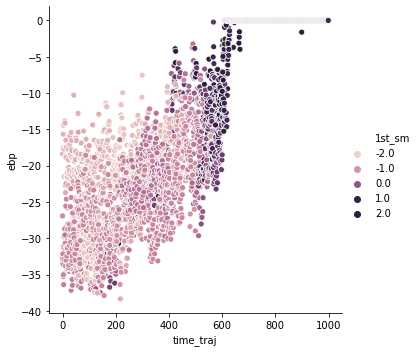

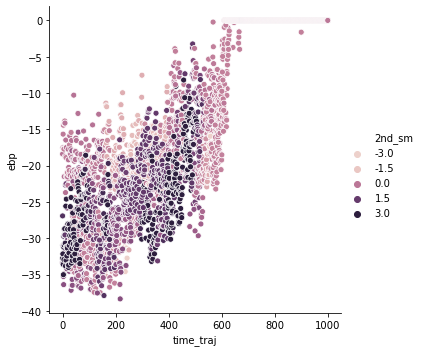

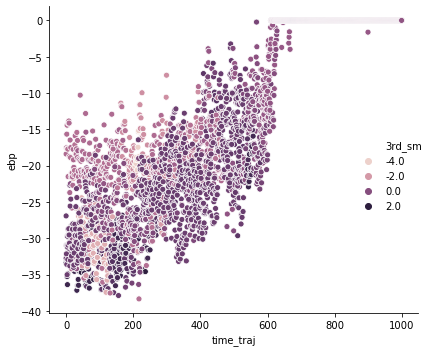

In [247]:
## thermo_features index: 
# Step(0) nbp(1) E_bond(2) E_angle(3) E_dihed(4) ebp(5) ecstk(6) eexcl(7) dna_ecou(8) Temp(9) time_traj (10)

sns.relplot(data = df,
            x = "time_traj", 
            y = "ebp", 
            hue = "1st_sm",
            )

sns.relplot(data = df,
            x = "time_traj", 
            y = "ebp", 
            hue = "2nd_sm",
            )

sns.relplot(data = df,
            x = "time_traj", 
            y = "ebp", 
            hue = "3rd_sm",
            )

plt.tight_layout()



## MSM

In [11]:
tica = py.coordinates.tica(pairwise_dis_s, lag=lag_time, var_cutoff=0.99)
tica_coords = np.concatenate(tica.get_output())

In [12]:
cluster = py.coordinates.cluster_kmeans(tica_coords, k=200, n_jobs=1, max_iter=50)

100%|██████████| 50/50 [00:27<00:00, 17.87s/it]                  


In [13]:
msm = py.msm.bayesian_markov_model(cluster.dtrajs, lag=lag_time)
print("Fraction of states used = {:.2f}".format(msm.active_state_fraction))
print("Fraction of counts used = {:.2f}".format(msm.active_count_fraction))

100%|██████████| 100/100 [00:05<00:00, 17.38it/s]               

Fraction of states used = 1.00
Fraction of counts used = 1.00


In [14]:
eigvec = msm.eigenvectors_right()
dtrajs = np.concatenate(cluster.dtrajs)
msm_coords = eigvec[dtrajs,1:6]
msm_timescales = msm.sample_mean('timescales', k=20)
print(msm_timescales[:4])

[808.75677972  36.57383181  16.69828449   3.6630034 ]


## compare results

IndexError: too many indices for array

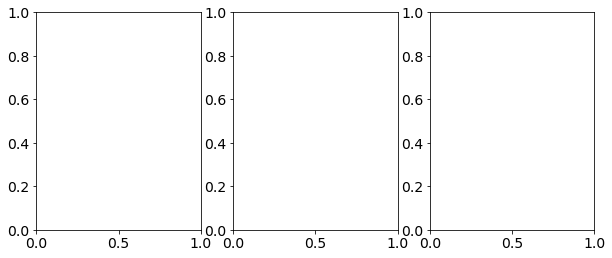

In [19]:
plt.rcParams['font.size'] = 14
def get_adp_state_plot(n_models):    
    skip = 10
    fig, axes = plt.subplots(n_models, 3)
    fig.set_size_inches(10, 3 * n_models + 1)

    #coords_list = [ktica_coords, hde_coords, msm_coords][:n_models]
    coords_list = [hde_coords][:n_models]
    #timescales_list = [ktica_timescales, hde_timescales, msm_timescales][:n_models]
    timescales_list = [hde_timescales][:n_models]
    for index_row in range(n_models):
        for item in range(2):
            #temp_coords = coords_list[index_row][::skip, item]
            temp_coords = np.concatenate(coords_list[index_row])[::skip, item]
            temp_coords *= np.sign(np.sum(temp_coords))
            ax = axes[index_row, item]
            im = ax.scatter(dihedrals[::skip, 0], dihedrals[::skip, 1], s=0.5, 
                                    c=temp_coords, cmap=plt.cm.RdBu)
            fig.colorbar(im, ax=ax, label='$\\tilde{\psi}_%d\ (t_%d = %d$ ps)' % (
                item + 1, item+1, timescales_list[index_row][item] * 2), fraction=0.046, pad=0.04)
            ax.text(-2, 0, '$\\alpha$', color='white')
            ax.text(-2.5, 2.2, '$\\beta$', color='white')
            ax.text(-1.5, 2.2, '$P_{//}$', color='white')
            ax.text(1.5, 0, '$\\alpha_L$')
            ax.text(1.5, 2.5, '$\\gamma$')
            ax.axis('square')
            ax.set_xlim([-np.pi, np.pi])
            ax.set_ylim([-np.pi, np.pi])
            if index_row == n_models - 1: ax.set_xlabel('$\phi$')
            if item == 0: ax.set_ylabel('$\psi$')

    row_label_list = ['kTICA', 'HDE', 'MSM'][:n_models]
    pad = 30 
    for ax, row in zip(axes[:, 0], row_label_list):
        ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', va='center', fontsize=20)
    plt.subplots_adjust(wspace=0.7, hspace=0.05)
    return fig

fig = get_adp_state_plot(1)